# Imports

In [1]:
# Load modules and set-up test problem
import sys
# sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

import cuqi
from cuqi.testproblem import Deconvolution1D
from cuqi.distribution import Gaussian, JointDistribution, GMRF
from cuqi.implicitprior import RegularizedGaussian
from cuqi.experimental.mcmc import RegularizedLinearRTO, MH, LinearRTO
from cuqi.geometry import StepExpansion

# Set seed
np.random.seed(24601)


# Set-up the problem

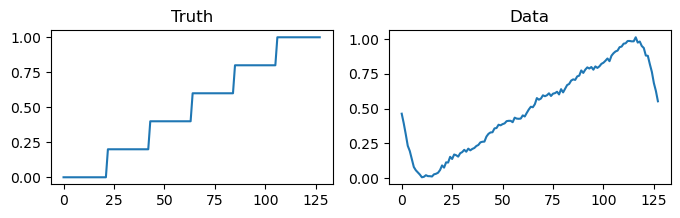

In [2]:
n = 128

x_true = np.zeros(n)

num_steps = 6
step_width = int(n/num_steps)
step_size = 1.0/(num_steps-1)
for i in range(1,num_steps):
    x_true[i*step_width+1:] += step_size

A, y_data, info = Deconvolution1D(dim=n, phantom=x_true, PSF_param = 5).get_components()

plt.figure(figsize = (8,2))
plt.subplot(1,2,1)
info.exactSolution.plot()
plt.title("Truth")

plt.subplot(1,2,2)
y_data.plot()
plt.title("Data")

plt.savefig("figures/staircase/stairs_data.pdf")

# Unconstrained

Warning (GMRF): Periodic and Neumann boundary conditions are experimental. Sampling using LinearRTO may not produce fully accurate results.


Sample: 100%|██████████| 5000/5000 [00:28<00:00, 173.95it/s, acc rate: 100.00%]


Plotting 5 randomly selected samples


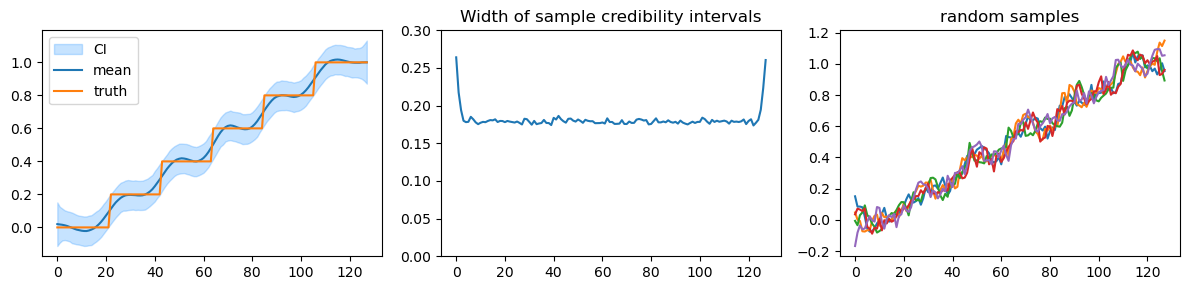

In [3]:
# General sampling parameters
num_samples = 5000
num_burnin = 100
thinning = 1

# Construct posterior
x = GMRF(np.zeros(n), prec = 500, bc_type='neumann')
y  = Gaussian(A@x, 0.001)
joint = JointDistribution(x, y)
posterior = joint(y=y_data)

# Sample
np.random.seed(24601)
sampler = LinearRTO(posterior) 
sampler.sample(num_samples, num_burnin)
samples = sampler.get_samples().burnthin(num_burnin, thinning)

# Create figure
plt.figure(figsize = (12,3))
plt.subplot(1,3,1)
samples.plot_ci()
plt.plot(info.exactSolution)
plt.legend(["CI", "mean", "truth"])

plt.subplot(1,3,2)
samples.plot_ci_width()
plt.ylim((0, 0.3))

plt.subplot(1,3,3)
samples.plot()
plt.title("random samples")

plt.tight_layout()
plt.savefig("figures/staircase/stairs_results_gaussian.pdf")

# Monotonically constrained Gaussian

In [4]:
# General sampling parameters
num_samples = 5000
num_burnin = 10
thinning = 1

# Construct posterior
x = RegularizedGaussian(np.zeros(n), prec = 10, constraint = "increasing")
y = Gaussian(A@x, 0.001)
posterior = JointDistribution(x, y)(y=y_data)

# Sample
np.random.seed(24601)
sampler = RegularizedLinearRTO(posterior,
                                    maxit=100,
                                    penalty_parameter = 100) 
sampler.sample(num_samples + num_burnin)
samples = sampler.get_samples().burnthin(num_burnin, thinning)

Sample: 100%|██████████| 5010/5010 [02:32<00:00, 32.75it/s, acc rate: 100.00%]


Plotting 5 randomly selected samples


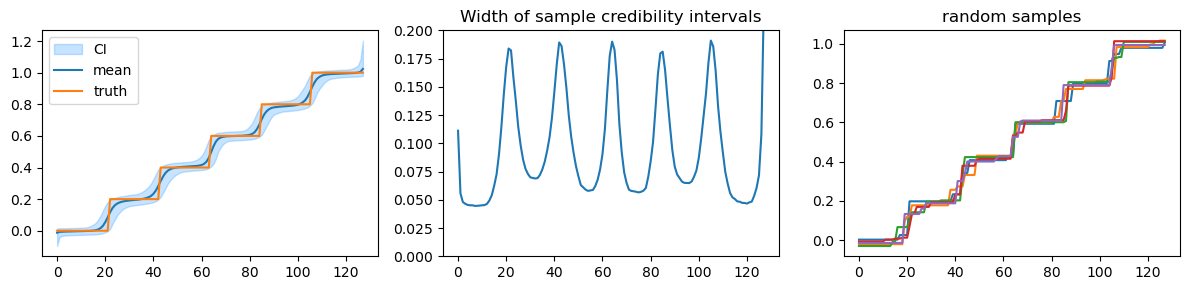

In [5]:
# Create figure
plt.figure(figsize = (12, 3))

plt.subplot(1,3,1)
samples.plot_ci()
plt.plot(info.exactSolution)
plt.legend(["CI","mean", "truth"])

plt.subplot(1,3,2)
samples.plot_ci_width()
plt.ylim((0, 0.2))

plt.subplot(1,3,3)
samples.plot()
plt.title("random samples")

plt.tight_layout()
plt.savefig("figures/staircase/stairs_results.pdf")

# Step expansion

In [9]:
# General sampling parameters
num_samples = 50000
num_burnin = 1000
thinning = 1

# Use geometries to realize the step expansion
num_steps = 9
geometry = StepExpansion(np.linspace(0,127,n), num_steps)
A.domain_geometry = geometry

# Construct posterior
x = Gaussian(np.zeros(num_steps), cov = 1)
y = Gaussian(A@x, 0.001)
posterior = JointDistribution(x, y)(y=y_data)

# Sample
np.random.seed(24601)
sampler = MH(posterior, scale = 0.01)
sampler.sample(num_samples + num_burnin)
samples = sampler.get_samples().burnthin(num_burnin, thinning)

Sample: 100%|██████████| 51000/51000 [03:19<00:00, 255.92it/s, acc rate: 20.31%]


Selecting 5 randomly chosen variables


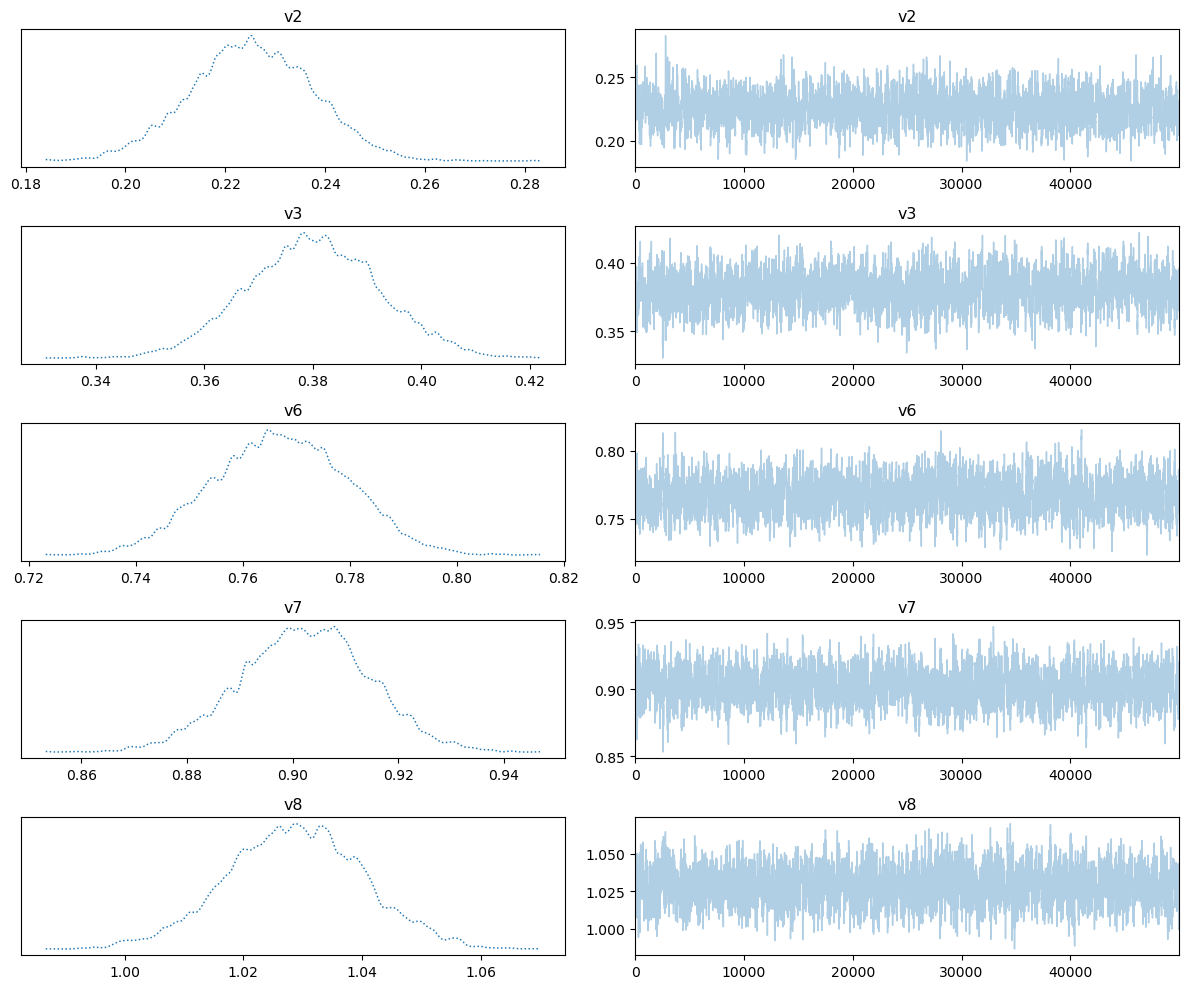

In [12]:
samples.plot_trace();

Plotting 5 randomly selected samples


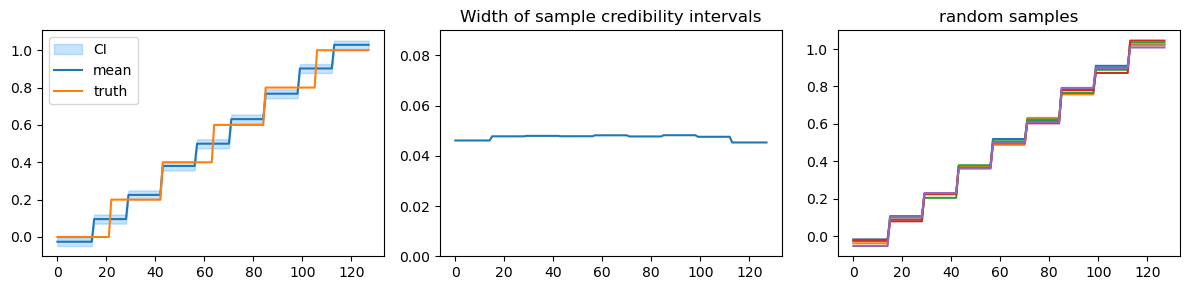

In [13]:
# Create figure
plt.figure(figsize = (12, 3))

plt.subplot(1,3,1)
samples.plot_ci()
plt.plot(np.linspace(0,127,n), info.exactSolution)
plt.legend([ "CI", "mean", "truth"])

plt.subplot(1,3,2)
samples.plot_ci_width()
plt.ylim((0, 0.09))

plt.subplot(1,3,3)
samples.plot()
plt.title("random samples")

plt.tight_layout()
plt.savefig("figures/staircase/stairs_stepexpansion.pdf")